Let's load the data now.

In [109]:
import pandas as pd 
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [110]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/Users/rewanabdelqader/Collage/Semster 8/Graduation Project/DS/places csv.csv')

# Split the data into two separate columns
df[['place_name', 'city']] = df['place_name'].str.split(' - ', expand=True)
# Print the updated DataFrame
df.head(5)

,place_id,place_name,popularity,rating_count,average_rating,budget,keywords,city
0,1,Montaza Palace Gardens,174.313947,400,4.0,300,"['cafe', 'dinner', 'lunch', 'coffee', 'brunch'...",None
1,2,Exit Games Egypt,170.926290,200,5.0,100,"['cafe', 'dinner', 'pastries', 'breakfast', 't...",Cairo
2,3,Roasting House,142.719149,500,5.0,300,"['tea', 'cafe', 'lunch', 'desserts']","New Cairo, Cairo"
3,4,Kharga Oasis,184.004065,300,3.5,100,['coffee'],None
4,5,The Secret Chambers Egypt,156.373940,500,4.0,300,"['dinner', 'tea', 'desserts', 'lunch', 'coffee...",Cairo


Now, we can filter out the places 

# **Content Based Filtering**
In this recommender system the content of the places (keywords, budget, rating, count rating,average rating etc) is used to find its similarity with other places. Then the places that are most likely to be similar are recommended.

![](https://image.ibb.co/f6mDXU/conten.png)

In [111]:


# add the budget and keywords features to the dataset
df['budget'] = df['budget'].astype(float)
df['keywords'] = df['keywords'].apply(lambda x: ' '.join(x))
df['features'] = df['keywords'] + ' ' + df['budget'].astype(str)

# create a tf-idf matrix for the features column
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['features'])



We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two places. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
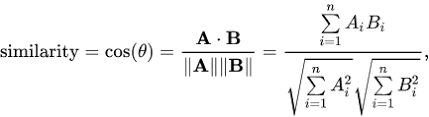

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [112]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a place name as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of place names and DataFrame indices. In other words, we need a mechanism to identify the index of a place in our metadata DataFrame, given its title.

In [113]:
# Construct a reverse map of indices and place names
indices = pd.Series(df.index, index=df['place_name']).drop_duplicates()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the place given its name.
* Get the list of cosine similarity scores for that particular movie with all places. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the place most similar to a particular place is the place itself).
* Return the titles corresponding to the indices of the top elements.

In [114]:
def get_similar_places(place_name, keywords=[], budget=np.inf, cosine_sim=cosine_sim, df=df):
    # Get the index of the place that matches the name
    idx = indices[place_name]

    # Get the pairwise similarity scores of all places with that place
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the places based on the average rating
    sim_scores = sorted(sim_scores, key=lambda x: df['average_rating'].iloc[x[0]], reverse=True)

    # Get the indices of the top 10 most similar places
    place_indices = [x[0] for x in sim_scores[1:11]]

    # Filter the places based on keywords and budget
    filtered_places = df.iloc[place_indices][df['budget'] <= budget]
    if keywords:
        filtered_places = filtered_places[filtered_places['keywords'].apply(lambda x: any(keyword in x for keyword in keywords))]

    # Select the relevant columns and return the filtered places sorted by average rating
    return filtered_places[['place_name', 'place_id', 'average_rating']].sort_values(by='average_rating', ascending=False)
get_similar_places('The Sunken City of Heracleion')

/var/folders/2s/0csdzgrs4gs5qz5648kq8qtr0000gn/T/ipykernel_3732/2254651051.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_places = df.iloc[place_indices][df['budget'] <= budget]


,place_name,place_id,average_rating
2,Roasting House,3,5.0
7,Al-Rahmaniyah Park,8,5.0
12,Lock'n'Load Egypt,13,5.0
19,The Greek Village,20,5.0
25,Al Horreya Park,26,5.0
32,Beit El Sennari,33,5.0
33,"I Bistro Bar, Cairo",34,5.0
44,Code to Escape Egypt,45,5.0
46,Aswan High Dam,47,5.0
49,Aqua Park,50,5.0


In [115]:
# define the recommendation function
def get_recommendations(place_name, city=None, budget=None, cosine_sim=cosine_sim):
    # filter the dataset based on the city and budget
    df_filtered = df.copy()

    if city:
        df_filtered = df_filtered[df_filtered['city'] == city]

    if budget:
        df_filtered = df_filtered[df_filtered['budget'] <= budget]

    # add the budget and keywords features to the filtered dataset
    df_filtered['budget'] = df_filtered['budget'].astype(float)
    df_filtered['keywords'] = df_filtered['keywords'].apply(lambda x: ' '.join(x))
    df_filtered['features'] = df_filtered['keywords'] + ' ' + df_filtered['budget'].astype(str)

    # create a tf-idf matrix for the features column in the filtered dataset
    tfidf_matrix_filtered = tfidf.transform(df_filtered['features'])

    # compute the pairwise similarity scores for the features
    sim_scores = list(enumerate(cosine_sim[indices[place_name]]))

    # sort the places based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get the indices of the top 10 most similar places
    sim_indices = [i for i, _ in sim_scores[1:11]]

    # return the names of the top 10 most similar places
    return df_filtered.loc[sim_indices, ['place_name', 'budget', 'average_rating', 'keywords']]

# example usage
get_recommendations('The Sunken City of Heracleion')

,place_name,budget,average_rating,keywords
9,Amazonia,1000.0,4.0,"[ ' d i n n e r ' , ' ..."
10,Pyramids Land,1000.0,4.5,"[ ' l u n c h ' , ' b ..."
15,Ramses Hilton,1000.0,4.5,[ ' d e s s e r t s ' ]
22,Marina Land,1000.0,4.5,"[ ' l u n c h ' , ' c ..."
23,The Sunken City of Heracleion,1000.0,3.5,"[ ' d i n n e r ' , ' ..."
24,The Escape Room Egypt,1000.0,4.5,"[ ' p a s t r i e s ' , ..."
36,The Tap West,1000.0,4.0,"[ ' b r u n c h ' , ' ..."
38,"Hard Rock Cafe, Cairo",1000.0,4.0,"[ ' t e a ' , ' d e s ..."
39,Ras El-Soda Beach,1000.0,4.5,"[ ' d e s s e r t s ' , ..."
40,El Sawy Culturewheel,1000.0,3.5,[ ' t e a ' ]


In [116]:
def get_recommendations(place_name, city=None, budget=None, cosine_sim=cosine_sim):
    # filter the dataset based on the city and budget
    df_filtered = df.copy()

    if city:
        df_filtered = df_filtered[df_filtered['city'] == city]

    if budget:
        df_filtered = df_filtered[df_filtered['budget'] <= budget]

    # add the budget and keywords features to the filtered dataset
    df_filtered['budget'] = df_filtered['budget'].astype(float)
    df_filtered['keywords'] = df_filtered['keywords'].apply(lambda x: ' '.join(x))
    df_filtered['features'] = df_filtered['keywords'] + ' ' + df_filtered['budget'].astype(str)

    # create a tf-idf matrix for the features column in the filtered dataset
    tfidf_matrix_filtered = tfidf.transform(df_filtered['features'])

    # compute the pairwise similarity scores for the features
    sim_scores = list(enumerate(cosine_sim[indices[place_name]]))

    # sort the places based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get the indices of the top 10 most similar places
    sim_indices = [i for i, _ in sim_scores[1:11]]

    # filter the places based on the number of similar keywords
    similar_keywords = set(df.loc[indices[place_name], 'keywords'])
    recommended_indices = []
    for index in sim_indices:
        if len(set(df_filtered.loc[index, 'keywords']).intersection(similar_keywords)) >= 3:
            recommended_indices.append(index)

    # return the names of the recommended places
    return df_filtered.loc[recommended_indices, ['place_name', 'budget', 'average_rating', 'keywords']]
get_recommendations('The Sunken City of Heracleion')

,place_name,budget,average_rating,keywords
9,Amazonia,1000.0,4.0,"[ ' d i n n e r ' , ' ..."
10,Pyramids Land,1000.0,4.5,"[ ' l u n c h ' , ' b ..."
15,Ramses Hilton,1000.0,4.5,[ ' d e s s e r t s ' ]
22,Marina Land,1000.0,4.5,"[ ' l u n c h ' , ' c ..."
23,The Sunken City of Heracleion,1000.0,3.5,"[ ' d i n n e r ' , ' ..."
24,The Escape Room Egypt,1000.0,4.5,"[ ' p a s t r i e s ' , ..."
36,The Tap West,1000.0,4.0,"[ ' b r u n c h ' , ' ..."
38,"Hard Rock Cafe, Cairo",1000.0,4.0,"[ ' t e a ' , ' d e s ..."
39,Ras El-Soda Beach,1000.0,4.5,"[ ' d e s s e r t s ' , ..."
40,El Sawy Culturewheel,1000.0,3.5,[ ' t e a ' ]


In [ ]:
# define the recommendation function
def get_recommendations(place_name, city=None, budget=None, cosine_sim=cosine_sim):
    # filter the dataset based on the city and budget
    df_filtered = df.copy()

    if city:
        df_filtered = df_filtered[df_filtered['city'] == city]

    if budget:
        df_filtered = df_filtered[df_filtered['budget'] <= budget]

    # add the budget and keywords features to the filtered dataset
    df_filtered['budget'] = df_filtered['budget'].astype(float)
    df_filtered['keywords'] = df_filtered['keywords'].apply(lambda x: ' '.join(x))
    df_filtered['features'] = df_filtered['keywords'] + ' ' + df_filtered['budget'].astype(str)

    # create a tf-idf matrix for the features column in the filtered dataset
    tfidf_matrix_filtered = tfidf.transform(df_filtered['features'])

    # compute the pairwise similarity scores for the features
    sim_scores = list(enumerate(cosine_sim[indices[place_name]]))

    # sort the places based on the similarity scores and average rating
    sim_scores = sorted(sim_scores, key=lambda x: (x[1], df_filtered.loc[x[0], 'average_rating']), reverse=True)

    # get the indices of the top 10 most similar places
    sim_indices = [i for i, _ in sim_scores[1:11]]

    # return the names of the top 10 most similar places
    return df_filtered.loc[sim_indices, ['place_name', 'budget', 'average_rating', 'keywords']]

# example usage
get_recommendations('The Sunken City of Heracleion')

,place_name,budget,average_rating,keywords
59,Sun City Mall,1000.0,5.0,"[ ' c a f e ' , ' p a ..."
69,Point 90 Mall,1000.0,5.0,"[ ' d e s s e r t s ' , ..."
89,30 June Stadium,1000.0,5.0,"[ ' p a s t r i e s ' , ..."
109,Coffee Republic,1000.0,5.0,"[ ' d e s s e r t s ' , ..."
112,Mystic Wadi,1000.0,5.0,[ ' p a s t r i e s ' ]
128,Cafe Greco,1000.0,5.0,"[ ' d e s s e r t s ' , ..."
131,The Waterway New Cairo,1000.0,5.0,"[ ' d i n n e r ' , ' ..."
133,Escape In Egypt,1000.0,5.0,"[ ' b r u n c h ' , ' ..."
144,Sindbad Aqua Park,1000.0,5.0,"[ ' t e a ' , ' c a f ..."
162,Alf Leila Wa Leila,1000.0,5.0,"[ ' c a f e ' , ' c o ..."


In [ ]:
# create a new tf-idf matrix for the features column
tfidf_matrix_features = tfidf.fit_transform(df['features'])

# compute the cosine similarity matrix
cosine_sim_features = linear_kernel(tfidf_matrix_features, tfidf_matrix_features)

# create a reverse map of indices and place names
indices = pd.Series(df.index, index=df['place_name'])

# define the recommendation function
def get_recommendations(place_name, cosine_sim_name=cosine_sim_name, cosine_sim_features=cosine_sim_features):
    # get the index of the place that matches the name
    idx = indices[place_name]

    # compute the pairwise similarity scores for the name and features
    sim_scores_name = list(enumerate(cosine_sim_name[idx]))
    sim_scores_features = list(enumerate(cosine_sim_features[idx]))

    # combine the two similarity scores by taking their average
    sim_scores = [(i, (score_name + score_feat) / 2)
                  for (i, score_name), (_, score_feat)
                  in zip(sim_scores_name, sim_scores_features)]

    # sort the places based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get the indices of the top 10 most similar places
    sim_indices = [i for i, _ in sim_scores[1:11]]

    # return the names of the top 10 most similar places
    return df.loc[sim_indices, 'place_name']

# example usage
get_recommendations('The Sunken City of Heracleion')

398      Cairo Festival City
59             Sun City Mall
277            Al Rehab City
7         Al-Rahmaniyah Park
9                   Amazonia
10             Pyramids Land
15             Ramses Hilton
22               Marina Land
24     The Escape Room Egypt
36              The Tap West
Name: place_name, dtype: object

In [ ]:
# define the recommendation function
def get_recommendations(place_name, cosine_sim=cosine_sim):
    # get the index of the place that matches the name
    idx = indices[place_name]

    # compute the pairwise similarity scores for the features
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort the places based on the similarity scores and average rating
    sim_scores = sorted(sim_scores, key=lambda x: (x[1], df.loc[x[0], 'average_rating']), reverse=True)

    # get the indices of the top 10 most similar places
    sim_indices = [i for i, _ in sim_scores[1:11]]

    # return the names of the top 10 most similar places
    return df.loc[sim_indices, 'place_name']

# example usage
get_recommendations('The Sunken City of Heracleion')

59              Sun City Mall
69              Point 90 Mall
89            30 June Stadium
109           Coffee Republic
112               Mystic Wadi
128                Cafe Greco
131    The Waterway New Cairo
133           Escape In Egypt
144         Sindbad Aqua Park
162        Alf Leila Wa Leila
Name: place_name, dtype: object

In [ ]:
def get_recommendations(place_name, city=None, budget=None, cosine_sim=cosine_sim):
    # Filter the dataset based on the city and budget
    df_filtered = df.copy()

    if city:
        df_filtered = df_filtered[df_filtered['city'] == city]

    if budget:
        df_filtered = df_filtered[df_filtered['budget'] <= budget]

    # Combine the keywords and budget columns into a single 'features' column
    df_filtered['features'] = df_filtered['keywords'].apply(lambda x: ' '.join(x)) + ' ' + df_filtered['budget'].astype(str)

    # Create a tf-idf matrix for the features column in the filtered dataset
    tfidf_matrix_filtered = tfidf.transform(df_filtered['features'])

    # Compute the pairwise similarity scores for the features
    sim_scores = list(enumerate(cosine_sim[indices[place_name]]))

    # Sort the places based on the similarity scores and average rating
    sim_scores = sorted(sim_scores, key=lambda x: (x[1], df_filtered.loc[x[0], 'average_rating']), reverse=True)

    # Get the indices of the top 10 most similar places
    sim_indices = [i for i, _ in sim_scores[5:11]]

    # Return a dataframe with the top 10 most similar places
    recommendations = df_filtered.loc[sim_indices, ['place_name', 'budget', 'average_rating', 'keywords']]
    recommendations = recommendations.rename(columns={'place_name': 'Place Name',
                                                      'budget': 'Budget',
                                                      'average_rating': 'Average Rating',
                                                      'keywords': 'Keywords'})
    return recommendations
get_recommendations('The Sunken City of Heracleion')

,Place Name,Budget,Average Rating,Keywords
112,Mystic Wadi,1000.0,5.0,[ ' p a s t r i e s ' ]
128,Cafe Greco,1000.0,5.0,"[ ' d e s s e r t s ' , ' c o f f e e ' ]"
131,The Waterway New Cairo,1000.0,5.0,"[ ' d i n n e r ' , ' c o f f e e ' , ' t ..."
133,Escape In Egypt,1000.0,5.0,"[ ' b r u n c h ' , ' b r e a k f a s t ' , ..."
144,Sindbad Aqua Park,1000.0,5.0,"[ ' t e a ' , ' c a f e ' ]"
162,Alf Leila Wa Leila,1000.0,5.0,"[ ' c a f e ' , ' c o f f e e ' ]"
